In [1]:
import sys
sys.path.append('/lab-share/Neuro-Cohen-e2/Public/notebooks/gmiller/Lesion_Pipeline/')

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
from glob import glob
import os

import GNMPipeline as p


# Check file metrics and plot bad ones

In [3]:
subjects=glob('lesions/sub-*/*EasyReg.nii.gz')
print(subjects)

['lesions/sub-MGH008/sub-MGH008_space-T2w_desc-SkullStripped_to_icbm152_t1_tal_nlin_asym_09c_maskedspace-MNI_EasyReg.nii.gz']


In [4]:
MNI = '/lab-share/Neuro-Cohen-e2/Public/notebooks/gmiller/Pipeline/0_pipeline_scripts/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii.gz'

df = pd.DataFrame(columns=['file','subject', 'dice', 'jaccard', 'voxels_non-over'])

rows=[]

for i in subjects:

    sub_id=os.path.basename(i).split('_')[0]
    
    metrics=p.BrainImageMetrics(i, MNI)
    
    dice= metrics.compute_dice_coefficient()
    jaccard=metrics.compute_jaccard_coefficient()
    voxels_nonoverlapping=metrics.compute_non_overlapping_percentage()
    
    if voxels_nonoverlapping > 5:
        score = 1
    else:
        score = 0
    
    row = {'file': i, 'subject': sub_id, 'dice': dice, 'jaccard': jaccard, 'voxels_non-over': voxels_nonoverlapping, 'concerning': score}
    rows.append(row)

df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
df.to_csv('MNI_Quick_Check.csv', index=False)
    

In [6]:
files_to_check=df[df['concerning']==1]
print("There are", len(files_to_check), "that need to be checked")

1

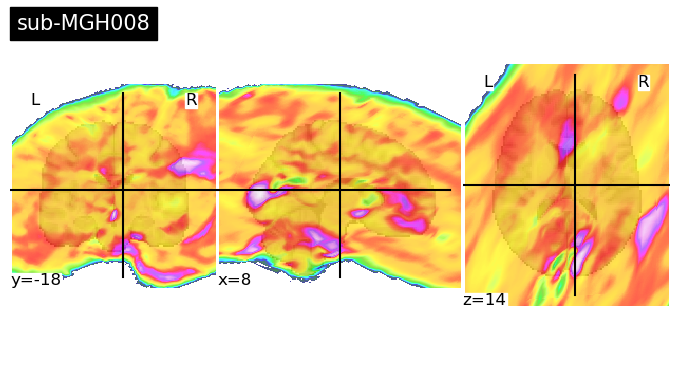

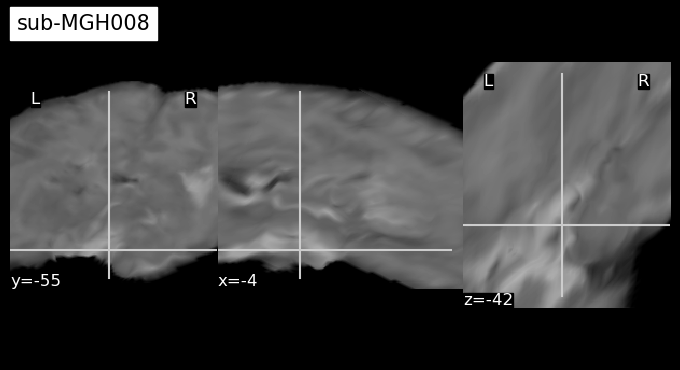

In [7]:
for file,subject in zip(files_to_check['file'].tolist(),files_to_check['subject'].tolist()) :
    plotting.plot_roi(file, title=subject)
    plotting.plot_anat(file, title=subject)

# Re-register bad ones

In [9]:
# df=pd.read_csv('MNI_Quick_Check.csv')
# files_to_check=df[df['concerning']==1]

In [ ]:
brains = []
lesions = []

for subject in files_to_check['subject'].tolist():
    brain = [i for i in glob(f'lesions/{subject}/*SkullStripped*') if 'MNI' not in i]
    lesion = [i for i in glob(f'lesions/{subject}/*lesion*') if 'MNI' not in i]
    
    brains.extend(brain)
    lesions.extend(lesion)
#print(brains)
#print(lesions)

In [ ]:
outputs=[]
for i in brains:
    prefix=i[0].split('.')[0]
    outname=prefix + "_synthseg.nii.gz"
    print(outname)
    outputs.append(outname)

p.synthseg_wrapper(brains,outputs,synthseg_robust=True, clean_up=False)

In [41]:
target_brain_seg='icbm152_t1_tal_nlin_asym_09c_masked_synthseg.nii.gz'

mni_reg_dict={}
for subject,brain,lesion in zip(files_to_check['subject'].tolist(),brains,lesions):
    command=p.easy_reg(f'lesions/{subject}', brain, 
            '/lab-share/Neuro-Cohen-e2/Public/lesions/MGH_Perinatal_Stroke_BIDS/code/bids_lesion_code/icbm152_t1_tal_nlin_asym_09c_masked.nii.gz', 
            target_brain_seg=target_brain_seg, source_brain_seg=None,
            lesion_mask=lesion[0], tag='space-MNI_EasyReg', other_brains=None, synthseg_robust=False)

    job_name = f"MNI-register_{subject}"
    job_id=p.submit_slurm_job_test(job_name, command)
    mni_reg_dict[(subject)] = job_id
        
    